In [1]:
# Installing dependencies 

import os, json, time, threading, queue
import numpy as np
import sounddevice as sd
import soundfile as sf
import librosa
import cv2
import matplotlib.pyplot as plt
import onnxruntime as ort
from IPython.display import Audio, clear_output

In [2]:
# Configuration

# Audio & feature extraction
SAMPLE_RATE = 16000
CHUNK_SEC   = 1.0
N_FFT       = 1024
HOP_LEN     = 256
N_MELS      = 64
IMG_SIZE    = 224

# Model config
NORMALIZE_MODE = 'tf'      # 'tf' for [-1,1], 'torch' for ImageNet mean/std
INPUT_LAYOUT   = 'NHWC'    # 'NHWC' for TF/TFLite, 'NCHW' for PyTorch
MODEL_PATH     = 'models/model.onnx'   # change to your model path

# Detection
THRESHOLD = 0.6
EVENT_DIR = 'events'
os.makedirs(EVENT_DIR, exist_ok=True)

In [3]:
# Audio capturing

CHUNK_SIZE = int(SAMPLE_RATE * CHUNK_SEC)
audio_q = queue.Queue(maxsize=8)
stop_flag = threading.Event()

def _audio_cb(indata, frames, time_info, status):
    if status:
        print('Audio status:', status)
    try:
        audio_q.put_nowait(indata[:,0].copy())  
    except queue.Full:
        pass

stream = None

def start_audio():
    global stream
    stop_flag.clear()
    stream = sd.InputStream(samplerate=SAMPLE_RATE, channels=1, dtype='float32',
                            blocksize=CHUNK_SIZE, callback=_audio_cb)
    stream.start()
    print("Audio stream started.")

def stop_audio():
    global stream
    stop_flag.set()
    if stream:
        stream.stop(); stream.close()
        stream = None
    print("Audio stream stopped.")


In [6]:
# Mel spectogram

def melspec_3ch(y, sr):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                         hop_length=HOP_LEN, n_mels=N_MELS, power=2.0)
    logmel = librosa.power_to_db(mel, ref=np.max)
    d1 = librosa.feature.delta(logmel)
    d2 = librosa.feature.delta(logmel, order=2)

    img = np.stack([logmel, d1, d2], axis=-1)  # (n_mels, time, 3)

    mn = img.min(axis=(0,1), keepdims=True)
    mx = img.max(axis=(0,1), keepdims=True)
    img01 = (img - mn) / (mx - mn + 1e-9)

    img01 = cv2.resize(img01.astype(np.float32), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    if NORMALIZE_MODE == 'tf':
        img_norm = img01 * 2 - 1
    elif NORMALIZE_MODE == 'torch':
        mean = np.array([0.485,0.456,0.406], np.float32)
        std  = np.array([0.229,0.224,0.225], np.float32)
        img_norm = (img01 - mean) / std
    else:
        img_norm = img01

    if INPUT_LAYOUT == 'NHWC':
        return img_norm[None,...].astype(np.float32)
    else:
        return np.transpose(img_norm, (2,0,1))[None,...].astype(np.float32)

In [9]:
import os
os.makedirs("models", exist_ok=True)

# Download MobileNetV2 ONNX model using curl
!curl -L https://github.com/onnx/models/raw/main/vision/classification/mobilenet/model/mobilenetv2-7.onnx -o models/model.onnx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  284k    0  284k    0     0   481k      0 --:--:-- --:--:-- --:--:--  485k


In [13]:
def softmax(z):
    z = z - np.max(z)
    e = np.exp(z)
    return e / np.sum(e)

def fake_inference(x):
    # Pretend we have 5 classes
    probs = np.random.rand(5)
    return probs / np.sum(probs)

In [16]:
# Process & detect

def worker_loop():
    i = 0
    while not stop_flag.is_set():
        try:
            y = audio_q.get(timeout=0.5)
        except queue.Empty:
            continue

        x = melspec_3ch(y, SAMPLE_RATE)
        probs = fake_inference(x)
        cls = int(np.argmax(probs))
        conf = float(np.max(probs))

        print(f"chunk {i}: cls={cls}, conf={conf:.3f}")

        if conf >= THRESHOLD:
            ts = int(time.time())
            wav_path = f"{EVENT_DIR}/event_{ts}_{i}.wav"
            sf.write(wav_path, y, SAMPLE_RATE)
            meta = {"time": ts, "chunk": i, "class": cls, "conf": conf, "wav": wav_path}
            json.dump(meta, open(f"{EVENT_DIR}/event_{ts}_{i}.json", "w"))

        i += 1

In [17]:
# Running

# Start processing
worker_thread = threading.Thread(target=worker_loop, daemon=True)
start_audio()
worker_thread.start()

Audio stream started.
chunk 0: cls=4, conf=0.397
chunk 1: cls=1, conf=0.340
chunk 2: cls=3, conf=0.490
chunk 3: cls=3, conf=0.356
chunk 4: cls=0, conf=0.398
chunk 5: cls=3, conf=0.298
chunk 6: cls=1, conf=0.390
chunk 7: cls=1, conf=0.426
chunk 8: cls=2, conf=0.374
chunk 9: cls=2, conf=0.350
chunk 10: cls=2, conf=0.296
chunk 11: cls=3, conf=0.247
chunk 12: cls=4, conf=0.335
chunk 13: cls=1, conf=0.319
chunk 14: cls=1, conf=0.302
chunk 15: cls=1, conf=0.330
chunk 16: cls=4, conf=0.318
chunk 17: cls=3, conf=0.312
chunk 18: cls=0, conf=0.315
chunk 19: cls=2, conf=0.319


In [18]:
stop_audio()

Audio stream stopped.


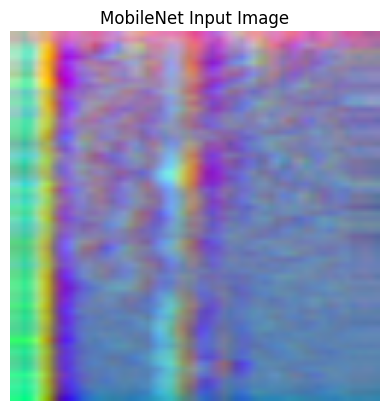

In [21]:
# Testing

rec = sd.rec(int(SAMPLE_RATE*CHUNK_SEC), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
sd.wait()
x = melspec_3ch(rec[:,0], SAMPLE_RATE)
plt.imshow((x[0] - x[0].min()) / (x[0].max() - x[0].min() + 1e-9))
plt.title("MobileNet Input Image")
plt.axis('off')
plt.show()